In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from PIL import Image
from utils import tile_raster_images
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("dark")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
0 0.311808
55 0.0324905
110 0.0215553
165 0.0191762
220 0.0190625
275 0.0170919
330 0.014843
385 0.016328
440 0.0155848
495 0.0139681


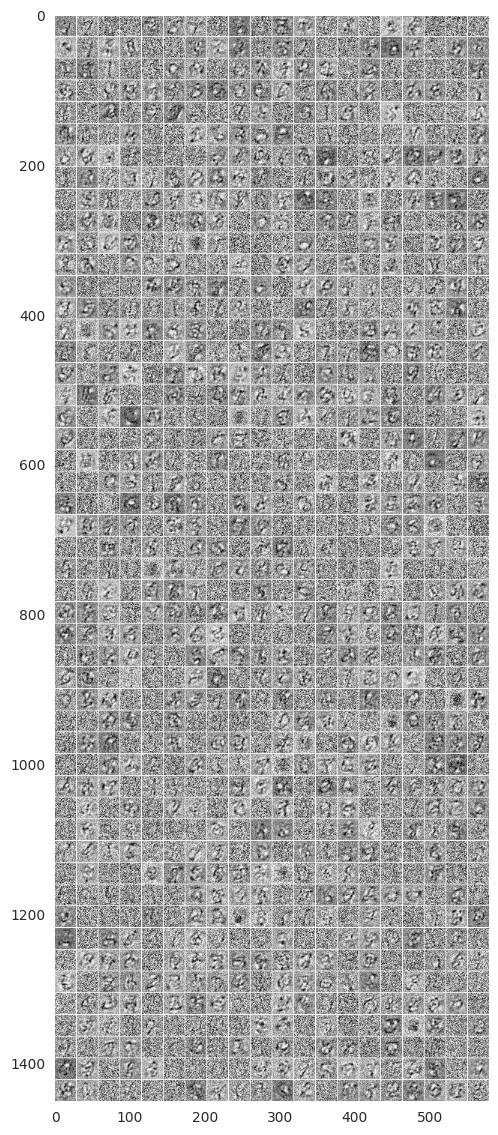

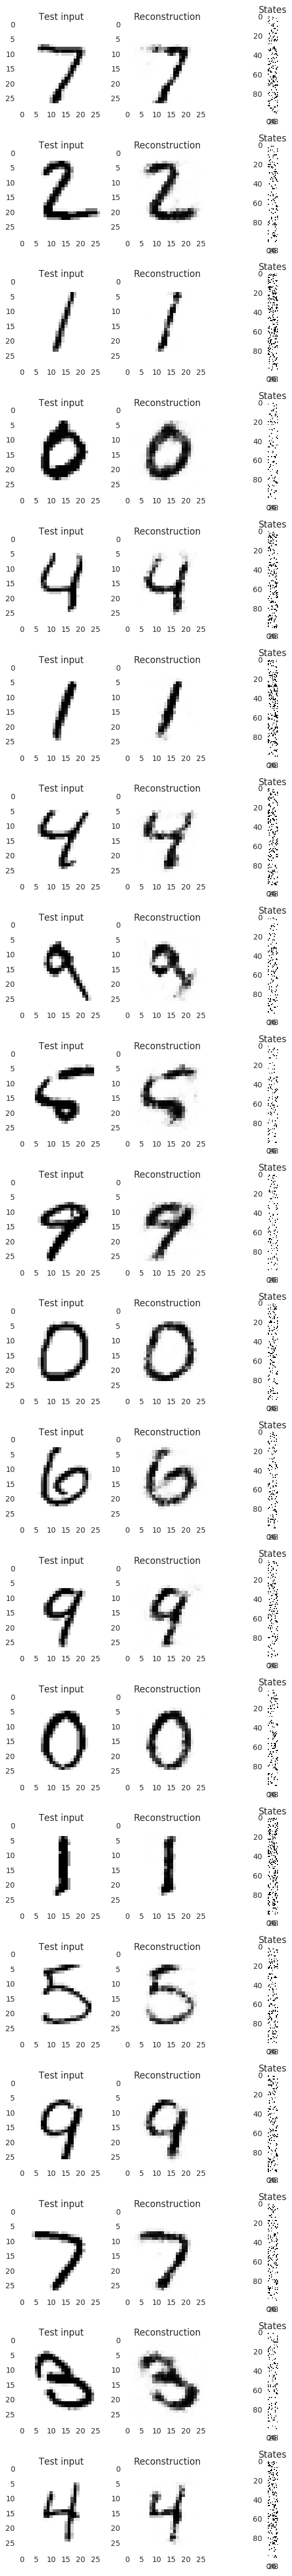

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images,\
    mnist.test.labels

def weights(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias(shape):
    initial = tf.zeros(shape, dtype=tf.float32)
    return tf.Variable(initial)

def sample_prob(probs):
    """Uzorkovanje vektora x prema vektoru vjerojatnosti p(x=1) = probs"""
    return tf.to_float(tf.random_uniform(tf.shape(probs)) <= probs)


def draw_weights(W, shape, N, interpolation="bilinear"):
    """Vizualizacija težina
    
    W -- vektori težina
    shape -- tuple dimenzije za 2D prikaz težina - obično dimenzije ulazne slike, npr. (28,28)
    N -- broj vektora težina
    """
    image = Image.fromarray( tile_raster_images(
        X=W.T,
        img_shape=shape,
        tile_shape=(int(math.ceil(N/20)), 20),
        tile_spacing=(1, 1)))
    plt.figure(figsize=(10, 14))
    plt.imshow(image, interpolation=interpolation)
    
def draw_reconstructions(ins, outs, states, shape_in, shape_state, Nh):
    """Vizualizacija ulaza i pripadajućih rekonstrkcija i stanja skrivenog sloja
    ins -- ualzni vektori
    outs -- rekonstruirani vektori
    states -- vektori stanja skrivenog sloja
    shape_in -- dimezije ulaznih slika npr. (28,28)
    shape_state -- dimezije za 2D prikaz stanja (npr. za 100 stanja (10,10)
    """
    plt.figure(figsize=(8, 12*4))
    for i in range(20):
        plt.subplot(20, 4, 4*i + 1)
        plt.imshow(ins[i].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Test input")
        plt.subplot(20, 4, 4*i + 2)
        plt.imshow(outs[i][0:784].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Reconstruction")
        plt.subplot(20, 4, 4*i + 3)
        plt.imshow(states[i][0:Nh].reshape(shape_state), vmin=0, vmax=1, interpolation="nearest")
        plt.title("States")
    plt.tight_layout()

Nv = 784
v_shape = (28,28)
Nh = 1000
h1_shape = (100,10)

gibbs_sampling_steps = 2
alpha = 0.1 # koeficijent učenja 

g1 = tf.Graph()
with g1.as_default():
    X1 = tf.placeholder("float", [None, 784])
    w1 = weights([Nv, Nh])  # num_features x num_hidden
    vb1 = bias([Nv])
    hb1 = bias([Nh])
    
    v0_prob = X1  # batch_size x num_features
    h0_prob = tf.nn.sigmoid(tf.matmul(v0_prob, w1) + hb1) # batch_size x num_hidden
    h0 = sample_prob(h0_prob)
    
    h1 = h0
    for step in range(gibbs_sampling_steps):
        v1_prob = tf.nn.sigmoid(tf.matmul(h1, tf.transpose(w1)) + vb1)
        v1 = sample_prob(v1_prob)
        h1_prob = tf.nn.sigmoid(tf.matmul(v1, w1) + hb1)
        h1 = sample_prob(h1_prob)
    
    # pozitivna faza
    w1_positive_grad = tf.matmul(tf.transpose(v0_prob), h0_prob)
    
    # negativna faza
    w1_negative_grad = tf.matmul(tf.transpose(v1_prob), h1_prob)

    dw1 = (w1_positive_grad - w1_negative_grad) / tf.to_float(tf.shape(X1)[0])

    # operacije za osvježavanje parametara mreže - one pokreću učenje RBM-a
    update_w1 = tf.assign_add(w1, alpha * dw1)
    update_vb1 = tf.assign_add(vb1, alpha * tf.reduce_mean(X1 - v1_prob, 0))
    update_hb1 = tf.assign_add(hb1, alpha * tf.reduce_mean(h0 - h1, 0)) 

    out1 = tf.group(update_w1, update_vb1, update_hb1)
    
    # rekonstrukcija ualznog vektora - koristimo vjerojatnost p(v=1)
    v1_prob = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(w1)) + vb1)
    
    err1 = X1 - v1_prob
    err_sum1 = tf.reduce_mean(err1 * err1)
    
batch_size = 100
epochs = 1
n_samples = mnist.train.num_examples

total_batch = int(n_samples / batch_size) * epochs

with tf.Session(graph=g1) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(total_batch):
        batch, label = mnist.train.next_batch(batch_size)
        err, _ = sess.run([err_sum1, out1], feed_dict={X1: batch})
        
        if i%(int(total_batch/10)) == 0:
            print (i, err)
    
    w1s = w1.eval()
    vb1s = vb1.eval()
    hb1s = hb1.eval()
    vr, h1s = sess.run([v1_prob, h1], feed_dict={X1: teX[:20,:]})

# vizualizacija težina
draw_weights(w1s, v_shape, Nh) 

# vizualizacija rekonstrukcije i stanja
draw_reconstructions(teX, vr, h1s, v_shape, h1_shape, Nh)

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import os

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

learning_rate = 0.001
batch_size = 100


n_hidden_recog_1=200 # 1 sloj enkodera
n_hidden_recog_2=200 # 2 sloj enkodera
n_hidden_gener_1=200 # 1 sloj dekodera
n_hidden_gener_2=200 # 2 sloj dekodera
n_z=2 # broj skrivenih varijabli
n_input=784 # MNIST data input (img shape: 28*28)

def draw_reconstructions(ins, outs, states, shape_in, shape_state):
    """Vizualizacija ulaza i pripadajućih rekonstrkcija i stanja skrivenog sloja
    ins -- ualzni vektori
    outs -- rekonstruirani vektori
    states -- vektori stanja skrivenog sloja
    shape_in -- dimezije ulaznih slika npr. (28,28)
    shape_state -- dimezije za 2D prikaz stanja (npr. za 100 stanja (10,10)
    """
    plt.figure(figsize=(8, 12*4))
    for i in range(20):

        plt.subplot(20, 4, 4*i + 1)
        plt.imshow(ins[i].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Test input")
        plt.subplot(20, 4, 4*i + 2)
        plt.imshow(outs[i][0:784].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Reconstruction")
        plt.subplot(20, 4, 4*i + 3)
        plt.imshow(states[i][0:(shape_state[0] * shape_state[1])].reshape(shape_state), interpolation="nearest")
        plt.colorbar()
        plt.title("States")
    plt.tight_layout()

def weight_variable(shape, name):
    """Kreiranje težina"""
    # http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization
    return tf.get_variable(name, shape=shape,
            initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(shape):
    """Kreiranje pomaka"""
    initial = tf.zeros(shape, dtype=tf.float32)
    return tf.Variable(initial)

def variable_summaries(var, name):
    """Prikupljanje podataka za Tensorboard"""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.scalar_summary('mean/' + name, mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.scalar_summary('stddev/' + name, stddev)
        tf.scalar_summary('max/' + name, tf.reduce_max(var))
        tf.scalar_summary('min/' + name, tf.reduce_min(var))
        tf.histogram_summary(name, var)

def vae_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.softplus):
    """Kreiranje jednog skrivenog sloja"""
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
        # This Variable will hold the state of the weights for the layer
        with tf.name_scope('weights'):
            weights = weight_variable([input_dim, output_dim], layer_name + '/weights')
            variable_summaries(weights, layer_name + '/weights')
        with tf.name_scope('biases'):
            biases = bias_variable([output_dim])
            variable_summaries(biases, layer_name + '/biases')
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights) + biases
            tf.histogram_summary(layer_name + '/pre_activations', preactivate)
        activations = act(preactivate, name='activation')
        tf.histogram_summary(layer_name + '/activations', activations)
    return activations

tf.reset_default_graph() 
sess = tf.InteractiveSession()        

# definicije ulaznog tenzora
x = tf.placeholder(tf.float32, [None, n_input])

# TODO definirajte enkoiderski dio
layer_e1 = vae_layer(x, n_input, n_hidden_recog_1, 'layer_e1') 
layer_e2 = vae_layer(layer_e1, n_hidden_recog_1, n_hidden_recog_2, 'layer_e2')

with tf.name_scope('z'):
# definirajte skrivene varijable i pripadajući generator šuma
    z_mean = vae_layer(layer_e2, n_hidden_recog_2, n_z, 'z_mean', act=tf.identity)
    z_log_sigma_sq = vae_layer(layer_e2, n_hidden_recog_2, n_z, 'z_log_sigma', act=tf.identity)
    eps = tf.random_normal((batch_size, n_z), 0, 1, dtype=tf.float32)
                         
    z = z_mean + tf.sqrt(tf.exp(z_log_sigma_sq)) * eps
    tf.histogram_summary('z/activations', z)

# definirajte dekoderski dio
layer_d1 = vae_layer(z, n_z, n_hidden_gener_1, 'layer_d1') 
layer_d2 = vae_layer(layer_d1, n_hidden_gener_1, n_hidden_gener_2, 'layer_d2')
            
# definirajte srednju vrijednost rekonstrukcije
x_reconstr_mean = vae_layer(layer_d2, n_hidden_gener_2, n_input, 'layer_decoder')

x_reconstr_mean_out = tf.nn.sigmoid(x_reconstr_mean)

# definirajte dvije komponente funkcije cijene
with tf.name_scope('costs'):                         
    # komponenta funkcije cijene - unakrsna entropija
    cost1 = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(x, x_reconstr_mean), axis=0)
    print(cost1.get_shape())
    # komponenta funkcije cijene - KL divergencija
    cost2 = -0.5 * (1 + z_log_sigma_sq - z_mean - tf.exp(z_log_sigma_sq))
    print(cost2.get_shape())
    cost2 = tf.reduce_sum(cost2, axis=0)
    cost2 = tf.Print(cost2, [tf.shape(cost2)], message="bitches")
    cost = tf.reduce_mean(cost1 + cost2)   # average over batch
    tf.scalar_summary('cost', cost)
    tf.scalar_summary('cost_CE', cost1)
    tf.scalar_summary('cost_KL', cost2)

                         
# ADAM optimizer
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
                         
# Prikupljanje podataka za Tensorboard
merged = tf.merge_all_summaries()                        
train_writer = tf.train.SummaryWriter('train', sess.graph)

init = tf.initialize_all_variables()                         
sess.run(init)

saver = tf.train.Saver()

n_epochs = 10

for epoch in range(n_epochs):
    avg_cost = 0.
    total_batch = int(n_samples / batch_size)
    
    for i in range(total_batch):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        opt, cos = sess.run((optimizer, cost), feed_dict={x: batch_xs})
        avg_cost += cos / n_samples * batch_size
        
    if epoch % 10 == 9:
        print("Epoch:", '%04d' % (epoch+1),
              "cost=", "{:.9f}".format(avg_cost)) 
        run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
        run_metadata = tf.RunMetadata()
        summary, _ = sess.run([merged, optimizer], feed_dict={x: batch_xs}, 
                              options=run_options, run_metadata=run_metadata)
        train_writer.add_run_metadata(run_metadata, 'epoch%03d' % epoch)
        train_writer.add_summary(summary, i)
        
        saver.save(sess, os.path.join('train', "model.ckpt"), epoch)

train_writer.close()

# vizualizacija rekonstrukcije i stanja
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct, z_out = sess.run([x_reconstr_mean_out, z], feed_dict={x: x_sample})

draw_reconstructions(x_sample, x_reconstruct, z_out, (28, 28), (4,5))

# Vizualizacija raspored testnih uzoraka u 2D prostoru skrivenih varijabli - 1. način
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = sess.run(z_mean, feed_dict={x: x_sample})

plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()

# Vizualizacija raspored testnih uzoraka u 2D prostoru skrivenih varijabli - 2. način

nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]])
        x_mean = sess.run(x_reconstr_mean_out, feed_dict={z: np.repeat(z_mu,100,0)})
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper")
plt.tight_layout()
sess.close()


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that Te

ValueError: Dimensions must be equal, but are 784 and 2 for 'costs/add_1' (op: 'Add') with input shapes: [784], [2].